# Toy EDA

import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import cv2

In [ ]:
TRAIN_PATH = 'data/full/train'
IGNORE = ['.DS_Store']

train_images = []
train_labels = []

for label in os.listdir(TRAIN_PATH):
    if label in IGNORE:
        continue
    full_path = f'{TRAIN_PATH}/{label}'

    for filename in os.listdir(full_path):
        img = cv2.imread(os.path.join(full_path, filename))
        train_images.append(img)
        train_labels.append(label)

In [78]:
train_images[0].shape

(224, 224, 3)

To display images, I use `np.flip(train_images[0], axis=-1)` to change coloring 

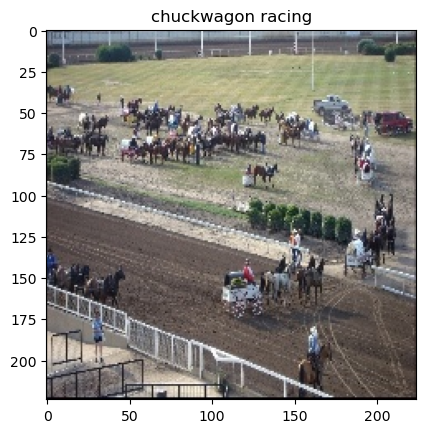

In [4]:
plt.imshow(np.flip(train_images[100], axis=-1))
plt.title(train_labels[100]);

See how everything works with grey scale, so we could reduce number of features

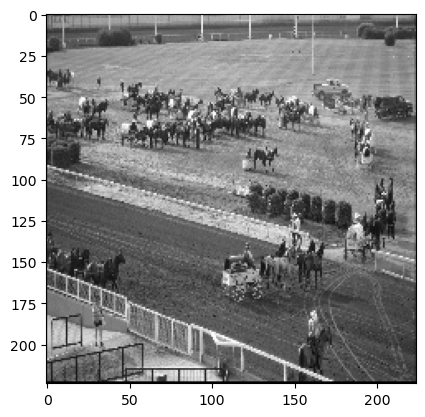

In [5]:
img = plt.imshow(train_images[100])
gray = lambda rgb : np.dot(rgb[... , :3] , [0.299 , 0.587, 0.114])
gray = gray(train_images[100])
plt.imshow(gray, cmap = plt.get_cmap(name = 'gray'))

In [6]:
samples = len(train_images)
train_images_combined = np.array(train_images).reshape(samples, 224 * 224 * 3)

# Deep Learning Approach

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets

In [3]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [6]:
train_dataset = datasets.ImageFolder(root='data/full/train/', transform=transform)

In [7]:
len(train_dataset.classes)

100

In [25]:
a = torch.arange(1, 17)

In [29]:
a.shape

torch.Size([16])

In [30]:
a.view(-1, 16).shape

torch.Size([1, 16])

In [31]:
a.flatten()

tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16])

In [49]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=64*54*54, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=100)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model = SimpleCNN().cuda()

In [50]:
print(model)

SimpleCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=186624, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=100, bias=True)
  )
)


In [48]:
next(iter(train_loader))[0].shape

torch.Size([32, 3, 224, 224])

In [51]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [52]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

num_epochs = 1
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.cuda(), labels.cuda()
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 100 == 99:
            print(f'Epoch {epoch + 1}, batch {i + 1}, loss: {running_loss / 100:.3f}')
            running_loss = 0.0

print('Finished training')

Epoch 1, batch 100, loss: 4.564
Epoch 1, batch 200, loss: 4.440
Epoch 1, batch 300, loss: 4.246
Epoch 1, batch 400, loss: 4.041
Finished training


In [21]:
torch.save(model.state_dict(), "weights")

In [13]:
test_dataset = datasets.ImageFolder(root='data/full/test/', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model.eval()

num_correct = 0
num_total = 0

with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        inputs, labels = inputs.cuda(), labels.cuda()
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        num_total += labels.size(0)
        num_correct += (predicted == labels).sum().item()

# Compute the accuracy
accuracy = num_correct / num_total
print(f'Test accuracy: {accuracy:.3f}')

Test accuracy: 0.296


Bad accuracy, because:
- Not enough observations
- No control of weight initilization procedure
- Too many classes

## Pretrained CNN: ConvNet as fixed feature extractor

### Main class

In [1]:
import time
import os

from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

class CNNClass():
    def __init__(self, model, transform, params, name,
                 path = 'data/full',
                 criterion = nn.CrossEntropyLoss(), 
                 optimizer = None,
                 device = 'cuda:0',
                 lr = 0.001):
        
        self.model = model
        self.transform = transform
        
        train_data = ImageFolder(f'{path}/train', transform=transform)
        valid_data = ImageFolder(f'{path}/valid', transform=transform)
        
        self.train_loader = DataLoader(train_data, batch_size=params['BATCH_SIZE'], shuffle=True, num_workers=2)
        self.valid_loader = DataLoader(valid_data, batch_size=params['BATCH_SIZE'], shuffle=True, num_workers=2)
        self.params = params
        self.name = name
        
        if not os.path.exists(f'weights/{self.name}'):
            os.mkdir(f'weights/{self.name}')

        self.criterion = criterion
        if optimizer == None:
            self.optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
        else:
            self.optimizer = optimizer
        self.device = device
    
    def train(self):
        start_time = time.time()

        self.losses = {
            'train_loss': list(),
            'val_loss': list()
               }

        best_val_loss = float('inf')
        epoch_no_improvement = 0
        best_epoch = 1
        for epoch in range(self.params['EPOCHS']):
            running_loss = 0.0
            val_loss = 0.0
            self.model.train()
            for images, labels in self.train_loader:
                images, labels = images.to(self.device), labels.to(self.device)
                self.optimizer.zero_grad()
                output = self.model(images)
                loss = self.criterion(output, labels)
                loss.backward()
                self.optimizer.step()
                running_loss += loss.item() * images.size(0)

            # Completed epoch, calculate validation error
            self.model.eval()
            with torch.no_grad():
                for images, labels in self.valid_loader:
                    images, labels = images.to(self.device), labels.to(self.device)
                    outputs = self.model(images)
                    loss = self.criterion(outputs, labels)
                    val_loss += loss.item() * images.size(0)

            epoch_loss = running_loss / len(self.train_loader.dataset)
            val_loss = val_loss / len(self.valid_loader.dataset)

            print(f'Epoch {epoch+1} Train loss: {epoch_loss:.3f}. Valid loss: {val_loss:.3f}')

            self.losses['train_loss'].append(epoch_loss)
            self.losses['val_loss'].append(val_loss)
            
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_epoch = epoch + 1
                epoch_no_improvement = 0
                state = {'model': self.model.state_dict(), 
                         'optimizer': self.optimizer.state_dict()}
                torch.save(state, f'weights/{self.name}/{self.name}.pth')
            else:
                epoch_no_improvement += 1
                
            if epoch_no_improvement == self.params['EARLY_STOP']:
                print(f'Training completed! No improvement last {epoch_no_improvement} epoches.' +
                      f'\nBest valid accuracy: {best_val_loss:.2f}' +
                      f'\nBest epoch: {best_epoch}')
                self.train_time = "%s" % (time.time() - start_time)
                break
        
        self.train_time = "%s" % (time.time() - start_time)
        self.save_info()
        print('-'*10)
        print(f'Test Accuracy: {self.test():.2f}%')   
                
    def test(self, path='data/full/test', debug=False):
        test_data = ImageFolder(path, transform=self.transform)
        test_loader = DataLoader(test_data, batch_size=self.params['BATCH_SIZE'], shuffle=True, num_workers=2)

        self.model.load_state_dict(torch.load(f'weights/{self.name}/{self.name}.pth', 
                                              map_location=self.device)['model'])
        self.optimizer.load_state_dict(torch.load(f'weights/{self.name}/{self.name}.pth',
                                                  map_location=self.device)['optimizer'])

        correct = 0
        total = 0
        self.model.eval()
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(self.device), labels.to(self.device)
                outputs = self.model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        return accuracy
    
    def save_info(self):
        # save time
        with open(f'weights/{self.name}/train_time.txt', 'w') as f:
            f.write(self.train_time)
        
        # save all stats
        with open(f'summary.csv', 'a') as f:
            f.write(f'{datetime.now().strftime("%d/%m/%Y %H:%M:%S")},{self.name},{self.train_time},{self.test()}\n')
        
        # save logs
        epoches = [i + 1 for i in range(len(self.losses['train_loss']))]
        with open(f'weights/{self.name}/accuracy_log.csv', 'w') as f:
            f.write("epoch,train_loss,valid_loss\n")
            for epoch, train_loss, valid_loss in zip(epoches, 
                                                     self.losses['train_loss'], 
                                                     self.losses['val_loss']):
                f.write(f"{epoch},{train_loss:.3f},{valid_loss:.3f}\n")
                
    def get_training_time(self):
        with open(f'weights/{self.name}/train_time.txt','r') as f:
            for line in f:
                print(np.round(float(line) / 60))
    
    def plot_accuracy(self):
        if os.path.exists(f'weights/{self.name}/accuracy_log.csv'):
            data = pd.read_csv(f'weights/{self.name}/accuracy_log.csv')
            fig, axs = plt.subplots(1, 1)
            axs.grid(alpha=0.4)
            axs.plot(data['epoch'],
                     data['train_loss'], label ='Train Loss', color='black')
            axs.plot(data['epoch'],
                     data['valid_loss'], label='Valid Loss', color='green')
            axs.legend()
            axs.set_xlabel('Epoch')
            axs.set_ylabel('Loss')
            axs.set_title(f'Loss for {self.name} model')
            return axs
        else:
            raise Exception(f'Missing weights/{self.name}/accuracy_log.csv')

#### AlexNet (native)

In [2]:
from torchvision.models import alexnet, AlexNet_Weights

device_sample = torch.device("cuda" if torch.cuda.is_available() else "cpu")
weights = AlexNet_Weights.DEFAULT
model_sample = alexnet(weights=weights)

for param in model_sample.parameters():
    param.requires_grad = False

model_sample.classifier[-1] = nn.Linear(model_sample.classifier[-1].in_features,
                                        100)
model_sample.to(device_sample)

transform_sample = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

model_params = {'BATCH_SIZE': 32,
                'EPOCHS': 50,
                'EARLY_STOP': 5}

model1 = CNNClass(model=model_sample,
                  transform=transform_sample,
                  params=model_params,
                  name='alexnet_native')

In [3]:
model1.train()

Epoch 1 Train loss: 1.582. Valid loss: 0.687
Epoch 2 Train loss: 0.756. Valid loss: 0.576
Epoch 3 Train loss: 0.567. Valid loss: 0.487
Epoch 4 Train loss: 0.455. Valid loss: 0.499
Epoch 5 Train loss: 0.386. Valid loss: 0.478
Epoch 6 Train loss: 0.328. Valid loss: 0.461
Epoch 7 Train loss: 0.298. Valid loss: 0.478
Epoch 8 Train loss: 0.270. Valid loss: 0.449
Epoch 9 Train loss: 0.242. Valid loss: 0.445
Epoch 10 Train loss: 0.220. Valid loss: 0.456
Epoch 11 Train loss: 0.201. Valid loss: 0.428
Epoch 12 Train loss: 0.183. Valid loss: 0.445
Epoch 13 Train loss: 0.172. Valid loss: 0.444
Epoch 14 Train loss: 0.166. Valid loss: 0.432
Epoch 15 Train loss: 0.156. Valid loss: 0.451
Epoch 16 Train loss: 0.148. Valid loss: 0.437
Training completed! No improvement last 5 epoches.
Best valid accuracy: 0.43
Best epoch: 11
----------
Test Accuracy: 86.80%


#### ResNet50 (native)

In [2]:
from torchvision.models import resnet50, ResNet50_Weights

device_sample = torch.device("cuda" if torch.cuda.is_available() else "cpu")
weights = ResNet50_Weights.DEFAULT
model_sample = resnet50(weights=weights)

for param in model_sample.parameters():
    param.requires_grad = False

model_sample.fc = nn.Linear(model_sample.fc.in_features, 100)

model_sample.to(device_sample)

transform_sample = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

model_params = {'BATCH_SIZE': 32,
                'EPOCHS': 50,
                'EARLY_STOP': 5}

model2 = CNNClass(model=model_sample,
                  transform=transform_sample,
                  params=model_params,
                  optimizer = optim.Adam(model_sample.parameters(), lr=0.0005),
                  name='resnet50_native')

In [5]:
model2.train()

Epoch 1 Train loss: 2.419. Valid loss: 1.182
Epoch 2 Train loss: 0.900. Valid loss: 0.733
Epoch 3 Train loss: 0.558. Valid loss: 0.464
Epoch 4 Train loss: 0.403. Valid loss: 0.349
Epoch 5 Train loss: 0.305. Valid loss: 0.326
Epoch 6 Train loss: 0.245. Valid loss: 0.278
Epoch 7 Train loss: 0.197. Valid loss: 0.251
Epoch 8 Train loss: 0.158. Valid loss: 0.231
Epoch 9 Train loss: 0.134. Valid loss: 0.228
Epoch 10 Train loss: 0.114. Valid loss: 0.215
Epoch 11 Train loss: 0.095. Valid loss: 0.204
Epoch 12 Train loss: 0.083. Valid loss: 0.215
Epoch 13 Train loss: 0.071. Valid loss: 0.187
Epoch 14 Train loss: 0.062. Valid loss: 0.181
Epoch 15 Train loss: 0.055. Valid loss: 0.178
Epoch 16 Train loss: 0.047. Valid loss: 0.191
Epoch 17 Train loss: 0.041. Valid loss: 0.170
Epoch 18 Train loss: 0.037. Valid loss: 0.185
Epoch 19 Train loss: 0.033. Valid loss: 0.170
Epoch 20 Train loss: 0.029. Valid loss: 0.153
Epoch 21 Train loss: 0.026. Valid loss: 0.152
Epoch 22 Train loss: 0.024. Valid loss: 0.1

#### ResNet152 (native)

In [6]:
from torchvision.models import resnet152, ResNet152_Weights

device_sample = torch.device("cuda" if torch.cuda.is_available() else "cpu")
weights = ResNet152_Weights.DEFAULT
model_sample = resnet152(weights=weights)

for param in model_sample.parameters():
    param.requires_grad = False

model_sample.fc = nn.Linear(model_sample.fc.in_features,
                            100)
model_sample.to(device_sample)

transform_sample = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

model_params = {'BATCH_SIZE': 32,
                'EPOCHS': 100,
                'EARLY_STOP': 5}

model3 = CNNClass(model=model_sample,
                  transform=transform_sample,
                  params=model_params,
                  name='resnet152_native')

Downloading: "https://download.pytorch.org/models/resnet152-f82ba261.pth" to /tmp/.xdg_cache_timoshenko_dmitrii/torch/hub/checkpoints/resnet152-f82ba261.pth
100%|██████████| 230M/230M [00:02<00:00, 112MB/s]  


In [ ]:
model3.train()

Epoch 1 Train loss: 3.955. Valid loss: 3.310
Epoch 2 Train loss: 2.779. Valid loss: 2.374
Epoch 3 Train loss: 2.029. Valid loss: 1.790
Epoch 4 Train loss: 1.582. Valid loss: 1.453
Epoch 5 Train loss: 1.313. Valid loss: 1.226
Epoch 6 Train loss: 1.139. Valid loss: 1.138
Epoch 7 Train loss: 1.015. Valid loss: 0.920
Epoch 8 Train loss: 0.918. Valid loss: 0.848
Epoch 9 Train loss: 0.843. Valid loss: 0.802
Epoch 10 Train loss: 0.786. Valid loss: 0.756
Epoch 11 Train loss: 0.736. Valid loss: 0.745
Epoch 12 Train loss: 0.700. Valid loss: 0.659
Epoch 13 Train loss: 0.659. Valid loss: 0.663
Epoch 14 Train loss: 0.631. Valid loss: 0.700
Epoch 15 Train loss: 0.601. Valid loss: 0.614
Epoch 16 Train loss: 0.581. Valid loss: 0.610
Epoch 17 Train loss: 0.556. Valid loss: 0.577
Epoch 18 Train loss: 0.540. Valid loss: 0.552


#### Inception V3 (native)

In [ ]:
from torchvision.models import inception_v3, Inception_V3_Weights

device_sample = torch.device("cuda" if torch.cuda.is_available() else "cpu")
weights = Inception_V3_Weights.DEFAULT
model_sample = inception_v3(weights=weights)

for param in model_sample.parameters():
    param.requires_grad = False

model_sample.fc = nn.Linear(model_sample.fc.in_features,
                      100)
model_sample.aux_logits=False
model_sample.to(device_sample)

transform_sample = transforms.Compose([
    transforms.Resize(299),
    transforms.CenterCrop(299),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

model_params = {'BATCH_SIZE': 32,
          'EPOCHS': 50,
          'EARLY_STOP': 5}

model4 = CNNClass(model=model_sample,
                  transform=transform_sample,
                  params=model_params,
                  name='inception-v3_native')

In [ ]:
model4.train()

#### EfficientNet-B3 (native)

In [ ]:
from torchvision.models import efficientnet_b3, EfficientNet_B3_Weights

device_sample = torch.device("cuda" if torch.cuda.is_available() else "cpu")
weights = EfficientNet_B3_Weights.DEFAULT
model_sample = efficientnet_b3(weights=weights)

for param in model_sample.parameters():
    param.requires_grad = False

model_sample.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1536, out_features=100)
)

model_sample.to(device_sample)

transform_sample = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Increased number of epochs

model_params = {'BATCH_SIZE': 32,
          'EPOCHS': 30,
          'EARLY_STOP': 4}

model5 = CNNClass(model=model_sample,
                  transform=transform_sample,
                  params=model_params,
                  optimizer = optim.Adam(model_sample.parameters(), lr=0.0005),
                  name='efficientnet-b3_native')

In [ ]:
model5.train()

#### EfficientNet-B6 (native)

In [ ]:
from torchvision.models import efficientnet_b6, EfficientNet_B6_Weights

device_sample = torch.device("cuda" if torch.cuda.is_available() else "cpu")
weights = EfficientNet_B6_Weights.DEFAULT
model_sample = efficientnet_b6(weights=weights)

for param in model_sample.parameters():
    param.requires_grad = False

model_sample.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=2304, out_features=100)
)

model_sample.to(device_sample)

transform_sample = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Increased number of epochs

model_params = {'BATCH_SIZE': 32,
                'EPOCHS': 100,
                'EARLY_STOP': 4}

model6 = CNNClass(model=model_sample,
                  transform=transform_sample,
                  params=model_params,
                  optimizer = optim.Adam(model_sample.parameters(), lr=0.0005),
                  name='efficientnet-b6_native')

In [ ]:
model6.train()

#### EfficientNetV2-S (native)

In [ ]:
from torchvision.models import efficientnet_v2_s, EfficientNet_V2_S_Weights

device_sample = torch.device("cuda" if torch.cuda.is_available() else "cpu")
weights = EfficientNet_V2_S_Weights.DEFAULT
model_sample = efficientnet_v2_s(weights=weights)

for param in model_sample.parameters():
    param.requires_grad = False

model_sample.classifier[-1] = nn.Linear(model_sample.classifier[-1].in_features,
                                        100)
model_sample.to(device_sample)

transform_sample = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

model_params = {'BATCH_SIZE': 32,
                'EPOCHS': 100,
                'EARLY_STOP': 5}

model7 = CNNClass(model=model_sample,
                  transform=transform_sample,
                  params=model_params,
                  name='efficientnetV2-S_native')

In [ ]:
model7.train()

#### EfficientNetV2-L (native)

Here, I need to tell what the difference between previous models and this one

In [ ]:
from torchvision.models import efficientnet_v2_l, EfficientNet_V2_L_Weights

device_sample = torch.device("cuda" if torch.cuda.is_available() else "cpu")
weights = EfficientNet_V2_L_Weights.DEFAULT
model_sample = efficientnet_v2_l(weights=weights)

for param in model_sample.parameters():
    param.requires_grad = False

model_sample.classifier[-1] = nn.Linear(model_sample.classifier[-1].in_features,
                                        100)
model_sample.to(device_sample)

transform_sample = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

model_params = {'BATCH_SIZE': 32,
                'EPOCHS': 100,
                'EARLY_STOP': 5}

model8 = CNNClass(model=model_sample,
                  transform=transform_sample,
                  params=model_params,
                  name='efficientnetV2-L_native')

In [ ]:
model8.train()

#### ViT-b-14 (native)

In [ ]:
from torchvision.models import vit_b_16, ViT_B_16_Weights

device_sample = torch.device("cuda" if torch.cuda.is_available() else "cpu")
weights = ViT_B_16_Weights.DEFAULT
model_sample = vit_b_16(weights=weights)

for param in model_sample.parameters():
    param.requires_grad = False

model_sample.heads.head = nn.Linear(model_sample.heads.head.in_features, 100)

model_sample.to(device_sample)

transform_sample = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Increased number of epochs

model_params = {'BATCH_SIZE': 32,
          'EPOCHS': 100,
          'EARLY_STOP': 5}

model9 = CNNClass(model=model_sample,
                  transform=transform_sample,
                  params=model_params,
                  optimizer = optim.SGD(model_sample.parameters(), lr=0.001, momentum=0.9, weight_decay=0.03),
                  name='vit-b-16_native')

In [ ]:
model9.train()

#### ViT-l-14 (native)

In [ ]:
from torchvision.models import vit_l_16, ViT_L_16_Weights

device_sample = torch.device("cuda" if torch.cuda.is_available() else "cpu")
weights = ViT_L_16_Weights.DEFAULT
model_sample = vit_l_16(weights=weights)

for param in model_sample.parameters():
    param.requires_grad = False

model_sample.heads.head = nn.Linear(model_sample.heads.head.in_features, 100)

model_sample.to(device_sample)

transform_sample = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

model_params = {'BATCH_SIZE': 32,
                'EPOCHS': 100,
                'EARLY_STOP': 5}

model10 = CNNClass(model=model_sample,
                  transform=transform_sample,
                  params=model_params,
                  optimizer = optim.SGD(model_sample.parameters(), lr=0.001, momentum=0.9, weight_decay=0.03),
                  name='vit-l-16_native')

In [ ]:
model10.train()

#### SuffleNet (x1) (native)

In [ ]:
from torchvision.models import shufflenet_v2_x1_0, ShuffleNet_V2_X1_0_Weights

device_sample = torch.device("cuda" if torch.cuda.is_available() else "cpu")
weights = ShuffleNet_V2_X1_0_Weights.DEFAULT
model_sample = shufflenet_v2_x1_0(weights=weights)

for param in model_sample.parameters():
    param.requires_grad = False

model_sample.fc = nn.Linear(model_sample.fc.in_features, 100)

model_sample.to(device_sample)

transform_sample = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Increased number of epochs

model_params = {'BATCH_SIZE': 32,
          'EPOCHS': 40,
          'EARLY_STOP': 5}

model11 = CNNClass(model=model_sample,
                  transform=transform_sample,
                  params=model_params,
                  optimizer = optim.SGD(model_sample.parameters(), lr=0.0001, momentum=0.9),
                  name='shufflenet-v2-x1-0_native')

In [ ]:
model11.train()

**Conclusion**: good idea to try small models, not large

## Use ResNet to Replace Classifier with Custom NN

### ResNet: CHANGE 1 (Adam-0.0005-DLReDL-ReLU)

In [15]:
from torchvision.models import resnet50, ResNet50_Weights

device_sample = torch.device("cuda" if torch.cuda.is_available() else "cpu")
weights = ResNet50_Weights.DEFAULT
model_sample = resnet50(weights=weights)

for param in model_sample.parameters():
    param.requires_grad = False

model_sample.fc = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(2048, 1024),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(1024, 100)
)

model_sample.to(device_sample)

transform_sample = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Increased number of epochs

model_params = {'BATCH_SIZE': 32,
          'EPOCHS': 100,
          'EARLY_STOP': 4}

model7 = CNNClass(model=model_sample,
                  transform=transform_sample,
                  params=model_params,
                  optimizer = optim.Adam(model_sample.parameters(), lr=0.0005),
                  name='resnet50_changed_(Adam-0.0005-DLReDL)')

In [16]:
model7.train()

Epoch 1 Train loss: 2.138. Valid loss: 0.575
Epoch 2 Train loss: 0.837. Valid loss: 0.352
Epoch 3 Train loss: 0.633. Valid loss: 0.272
Epoch 4 Train loss: 0.515. Valid loss: 0.228
Epoch 5 Train loss: 0.462. Valid loss: 0.202
Epoch 6 Train loss: 0.421. Valid loss: 0.226
Epoch 7 Train loss: 0.393. Valid loss: 0.175
Epoch 8 Train loss: 0.336. Valid loss: 0.170
Epoch 9 Train loss: 0.335. Valid loss: 0.171
Epoch 10 Train loss: 0.312. Valid loss: 0.198
Epoch 11 Train loss: 0.293. Valid loss: 0.170
Epoch 12 Train loss: 0.296. Valid loss: 0.168
Epoch 13 Train loss: 0.267. Valid loss: 0.176
Epoch 14 Train loss: 0.262. Valid loss: 0.175
Epoch 15 Train loss: 0.244. Valid loss: 0.156
Epoch 16 Train loss: 0.242. Valid loss: 0.184
Epoch 17 Train loss: 0.231. Valid loss: 0.164
Epoch 18 Train loss: 0.227. Valid loss: 0.148
Epoch 19 Train loss: 0.218. Valid loss: 0.146
Epoch 20 Train loss: 0.229. Valid loss: 0.161
Epoch 21 Train loss: 0.214. Valid loss: 0.160
Epoch 22 Train loss: 0.215. Valid loss: 0.1

### ResNet: CHANGE 2 (Adam-0.0005-DLReDLReDL-ReLU)

In [17]:
from torchvision.models import resnet50, ResNet50_Weights

device_sample = torch.device("cuda" if torch.cuda.is_available() else "cpu")
weights = ResNet50_Weights.DEFAULT
model_sample = resnet50(weights=weights)

for param in model_sample.parameters():
    param.requires_grad = False

model_sample.fc = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(2048, 1024),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(512, 100)
)

model_sample.to(device_sample)

transform_sample = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Increased number of epochs

model_params = {'BATCH_SIZE': 32,
          'EPOCHS': 100,
          'EARLY_STOP': 4}

model7 = CNNClass(model=model_sample,
                  transform=transform_sample,
                  params=model_params,
                  optimizer = optim.Adam(model_sample.parameters(), lr=0.0005),
                  name='resnet50_changed_(Adam-0.0005-DLReDLReDL)')

In [18]:
model7.train()

Epoch 1 Train loss: 2.818. Valid loss: 0.942
Epoch 2 Train loss: 1.246. Valid loss: 0.485
Epoch 3 Train loss: 0.955. Valid loss: 0.367
Epoch 4 Train loss: 0.807. Valid loss: 0.318
Epoch 5 Train loss: 0.703. Valid loss: 0.292
Epoch 6 Train loss: 0.649. Valid loss: 0.286
Epoch 7 Train loss: 0.582. Valid loss: 0.258
Epoch 8 Train loss: 0.556. Valid loss: 0.247
Epoch 9 Train loss: 0.508. Valid loss: 0.224
Epoch 10 Train loss: 0.495. Valid loss: 0.218
Epoch 11 Train loss: 0.485. Valid loss: 0.225
Epoch 12 Train loss: 0.450. Valid loss: 0.200
Epoch 13 Train loss: 0.433. Valid loss: 0.179
Epoch 14 Train loss: 0.418. Valid loss: 0.179
Epoch 15 Train loss: 0.415. Valid loss: 0.207
Epoch 16 Train loss: 0.400. Valid loss: 0.178
Epoch 17 Train loss: 0.377. Valid loss: 0.183
Epoch 18 Train loss: 0.376. Valid loss: 0.206
Epoch 19 Train loss: 0.364. Valid loss: 0.203
Epoch 20 Train loss: 0.360. Valid loss: 0.194
Training completed! No improvement last 4 epoches.
Best valid accuracy: 0.18
Best epoch: 

### ResNet: CHANGE 3 (SGD-0.001-DLReDL-ReLU)

In [21]:
from torchvision.models import resnet50, ResNet50_Weights

device_sample = torch.device("cuda" if torch.cuda.is_available() else "cpu")
weights = ResNet50_Weights.DEFAULT
model_sample = resnet50(weights=weights)

for param in model_sample.parameters():
    param.requires_grad = False

model_sample.fc = nn.Sequential(
    nn.Dropout(p=0.2),
    nn.Linear(2048, 1024),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(1024, 100)
)

model_sample.to(device_sample)

transform_sample = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Increased number of epochs

model_params = {'BATCH_SIZE': 32,
          'EPOCHS': 100,
          'EARLY_STOP': 4}

model7 = CNNClass(model=model_sample,
                  transform=transform_sample,
                  params=model_params,
                  optimizer = optim.SGD(model_sample.parameters(), lr=0.001, momentum=0.9),
                  name='resnet50_changed_classifier_(SGD-0.001-DLReDL)')

In [22]:
model7.train()

Epoch 1 Train loss: 4.521. Valid loss: 4.406
Epoch 2 Train loss: 4.243. Valid loss: 4.021
Epoch 3 Train loss: 3.732. Valid loss: 3.390
Epoch 4 Train loss: 3.033. Valid loss: 2.664
Epoch 5 Train loss: 2.362. Valid loss: 1.943
Epoch 6 Train loss: 1.869. Valid loss: 1.507
Epoch 7 Train loss: 1.530. Valid loss: 1.178
Epoch 8 Train loss: 1.302. Valid loss: 1.018
Epoch 9 Train loss: 1.140. Valid loss: 0.833
Epoch 10 Train loss: 1.018. Valid loss: 0.779
Epoch 11 Train loss: 0.928. Valid loss: 0.690
Epoch 12 Train loss: 0.849. Valid loss: 0.606
Epoch 13 Train loss: 0.787. Valid loss: 0.564
Epoch 14 Train loss: 0.741. Valid loss: 0.518
Epoch 15 Train loss: 0.703. Valid loss: 0.487
Epoch 16 Train loss: 0.656. Valid loss: 0.456
Epoch 17 Train loss: 0.628. Valid loss: 0.418
Epoch 18 Train loss: 0.591. Valid loss: 0.406
Epoch 19 Train loss: 0.566. Valid loss: 0.381
Epoch 20 Train loss: 0.547. Valid loss: 0.386
Epoch 21 Train loss: 0.525. Valid loss: 0.360
Epoch 22 Train loss: 0.510. Valid loss: 0.3

### ResNet: CHANGE 4 (Adam-0.0005-DLReDL-ELU)

In [23]:
from torchvision.models import resnet50, ResNet50_Weights

device_sample = torch.device("cuda" if torch.cuda.is_available() else "cpu")
weights = ResNet50_Weights.DEFAULT
model_sample = resnet50(weights=weights)

for param in model_sample.parameters():
    param.requires_grad = False

model_sample.fc = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(2048, 1024),
    nn.ELU(),
    nn.Dropout(p=0.5),
    nn.Linear(1024, 100)
)

model_sample.to(device_sample)

transform_sample = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Increased number of epochs

model_params = {'BATCH_SIZE': 32,
          'EPOCHS': 100,
          'EARLY_STOP': 4}

model7 = CNNClass(model=model_sample,
                  transform=transform_sample,
                  params=model_params,
                  optimizer = optim.Adam(model_sample.parameters(), lr=0.0005),
                  name='resnet50_changed_(Adam-0.0005-DLReDL-ELU)')

In [24]:
model7.train()

Epoch 1 Train loss: 1.895. Valid loss: 0.535
Epoch 2 Train loss: 0.702. Valid loss: 0.310
Epoch 3 Train loss: 0.522. Valid loss: 0.241
Epoch 4 Train loss: 0.446. Valid loss: 0.217
Epoch 5 Train loss: 0.394. Valid loss: 0.215
Epoch 6 Train loss: 0.349. Valid loss: 0.205
Epoch 7 Train loss: 0.335. Valid loss: 0.169
Epoch 8 Train loss: 0.313. Valid loss: 0.183
Epoch 9 Train loss: 0.299. Valid loss: 0.164
Epoch 10 Train loss: 0.281. Valid loss: 0.186
Epoch 11 Train loss: 0.267. Valid loss: 0.161
Epoch 12 Train loss: 0.258. Valid loss: 0.195
Epoch 13 Train loss: 0.258. Valid loss: 0.166
Epoch 14 Train loss: 0.241. Valid loss: 0.171
Epoch 15 Train loss: 0.255. Valid loss: 0.187
Training completed! No improvement last 4 epoches.
Best valid accuracy: 0.16
Best epoch: 11
----------
Test Accuracy: 96.01%


### ResNet: CHANGE 5 (Adam-0.0005-DLReDLReDL-ReLU)

In [25]:
from torchvision.models import resnet50, ResNet50_Weights

device_sample = torch.device("cuda" if torch.cuda.is_available() else "cpu")
weights = ResNet50_Weights.DEFAULT
model_sample = resnet50(weights=weights)

for param in model_sample.parameters():
    param.requires_grad = False

model_sample.fc = nn.Sequential(
    nn.Dropout(p=0.2),
    nn.Linear(2048, 1500),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(1500, 750),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(750, 100)
)

model_sample.to(device_sample)

transform_sample = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Increased number of epochs

model_params = {'BATCH_SIZE': 32,
          'EPOCHS': 100,
          'EARLY_STOP': 4}

model7 = CNNClass(model=model_sample,
                  transform=transform_sample,
                  params=model_params,
                  optimizer = optim.Adam(model_sample.parameters(), lr=0.0005),
                  name='resnet50_changed_classifier_(DLReDLReDL)_optimized')
model7.train()

Epoch 1 Train loss: 1.735. Valid loss: 0.485
Epoch 2 Train loss: 0.563. Valid loss: 0.307
Epoch 3 Train loss: 0.374. Valid loss: 0.294
Epoch 4 Train loss: 0.272. Valid loss: 0.281
Epoch 5 Train loss: 0.210. Valid loss: 0.230
Epoch 6 Train loss: 0.174. Valid loss: 0.224
Epoch 7 Train loss: 0.147. Valid loss: 0.250
Epoch 8 Train loss: 0.123. Valid loss: 0.217
Epoch 9 Train loss: 0.120. Valid loss: 0.265
Epoch 10 Train loss: 0.103. Valid loss: 0.209
Epoch 11 Train loss: 0.095. Valid loss: 0.229
Epoch 12 Train loss: 0.098. Valid loss: 0.264
Epoch 13 Train loss: 0.097. Valid loss: 0.273
Epoch 14 Train loss: 0.077. Valid loss: 0.260
Training completed! No improvement last 4 epoches.
Best valid accuracy: 0.21
Best epoch: 10
----------
Test Accuracy: 96.41%


### TEST MODEL

In [ ]:
from torchvision.models import resnet50, ResNet50_Weights

device_sample = torch.device("cuda" if torch.cuda.is_available() else "cpu")
weights = ResNet50_Weights.DEFAULT
model_sample = resnet50(weights=weights)

for param in model_sample.parameters():
    param.requires_grad = False

model_sample.fc = nn.Sequential(
    nn.Dropout(p=0.2),
    nn.Linear(2048, 1024),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(1024, 100)
)

model_sample.to(device_sample)

transform_sample = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Increased number of epochs

model_params = {'BATCH_SIZE': 32,
          'EPOCHS': 100,
          'EARLY_STOP': 4}

model7 = CNNClass(model=model_sample,
                  transform=transform_sample,
                  params=model_params,
                  optimizer = optim.SGD(model_sample.parameters(), lr=0.005, momentum=0.9),
                  name='resnet50_changed_classifier_(SGD-0.001-DLReDL)')
model7.train()

## Image augmentation on training dataset

### Main class

In [32]:
import time
import os

from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

class CNNClassExtended(CNNClass):
    def __init__(self, model, transforms_, params, name,
                 path = 'data/full',
                 criterion = nn.CrossEntropyLoss(), 
                 optimizer = None,
                 device = 'cuda:0',
                 lr = 0.001):
        
        self.model = model
        
        train_data = ImageFolder(f'{path}/train', transform=transforms_[0])
        valid_data = ImageFolder(f'{path}/valid', transform=transforms_[1])
        
        self.train_loader = DataLoader(train_data, batch_size=params['BATCH_SIZE'], shuffle=True)
        self.valid_loader = DataLoader(valid_data, batch_size=params['BATCH_SIZE'], shuffle=True)
        self.params = params
        self.name = name
        
        if not os.path.exists(f'weights/{self.name}'):
            os.mkdir(f'weights/{self.name}')

        self.criterion = criterion
        if optimizer == None:
            self.optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
        else:
            self.optimizer = optimizer
        self.device = device
    
    def test(self, path='data/full/test', transform=None, debug=False):
        
        if transform == None:
            transform = transform_valid = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])
            
        test_data = ImageFolder(path, transform=transform)
        test_loader = DataLoader(test_data, batch_size=self.params['BATCH_SIZE'], shuffle=True, num_workers=2)

        self.model.load_state_dict(torch.load(f'weights/{self.name}/{self.name}.pth', 
                                              map_location=self.device)['model'])
        self.optimizer.load_state_dict(torch.load(f'weights/{self.name}/{self.name}.pth',
                                                  map_location=self.device)['optimizer'])

        correct = 0
        total = 0
        self.model.eval()
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(self.device), labels.to(self.device)
                outputs = self.model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        return accuracy

#### Hard Augmentation

##### AlexNet (hard augmented)

In [46]:
from torchvision.models import alexnet, AlexNet_Weights

device_sample = torch.device("cuda" if torch.cuda.is_available() else "cpu")
weights = AlexNet_Weights.DEFAULT
model_sample = alexnet(weights=weights)

for param in model_sample.parameters():
    param.requires_grad = False

model_sample.classifier[-1] = nn.Linear(model_sample.classifier[-1].in_features,
                                        100)
model_sample.to(device_sample)

transform_test = transforms.Compose([
    transforms.RandomEqualize(p=0.1),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomPerspective(p=0.3, distortion_scale=0.2),
    transforms.RandomAutocontrast(p=0.3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_valid = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_sample = [transform_test, transform_valid]

model_params = {'BATCH_SIZE': 32,
                'EPOCHS': 100,
                'EARLY_STOP': 5}

model1 = CNNClassExtended(model=model_sample,
                  transforms_= transform_sample,
                  params=model_params,
                  name='alexnet_hard_aug')

In [ ]:
model1.train()

##### ResNet50 (hard augmented)

In [ ]:
from torchvision.models import resnet50, ResNet50_Weights

device_sample = torch.device("cuda" if torch.cuda.is_available() else "cpu")
weights = ResNet50_Weights.DEFAULT
model_sample = resnet50(weights=weights)

for param in model_sample.parameters():
    param.requires_grad = False

model_sample.fc = nn.Linear(model_sample.fc.in_features, 100)

model_sample.to(device_sample)

transform_test = transforms.Compose([
    transforms.RandomEqualize(p=0.1),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomPerspective(p=0.3, distortion_scale=0.2),
    transforms.RandomAutocontrast(p=0.3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_valid = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_sample = [transform_test, transform_valid]

model_params = {'BATCH_SIZE': 32,
                'EPOCHS': 100,
                'EARLY_STOP': 5}

model2 = CNNClassExtended(model=model_sample,
                  transforms_=transform_sample,
                  params=model_params,
                  optimizer = optim.Adam(model_sample.parameters(), lr=0.0005),
                  name='resnet50_hard_aug')

In [ ]:
model2.train()

##### ResNet152 (hard augmented)

In [ ]:
from torchvision.models import resnet152, ResNet152_Weights

device_sample = torch.device("cuda" if torch.cuda.is_available() else "cpu")
weights = ResNet152_Weights.DEFAULT
model_sample = resnet152(weights=weights)

for param in model_sample.parameters():
    param.requires_grad = False

model_sample.fc = nn.Linear(model_sample.fc.in_features,
                            100)
model_sample.to(device_sample)

transform_test = transforms.Compose([
    transforms.RandomEqualize(p=0.1),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomPerspective(p=0.3, distortion_scale=0.2),
    transforms.RandomAutocontrast(p=0.3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_valid = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_sample = [transform_test, transform_valid]

model_params = {'BATCH_SIZE': 32,
                'EPOCHS': 100,
                'EARLY_STOP': 5}

model3 = CNNClassExtended(model=model_sample,
                  transforms_=transform_sample,
                  params=model_params,
                  name='resnet152_hard_aug')

In [ ]:
model3.train()

###### Inception V3 (hard augmented)

In [48]:
from torchvision.models import inception_v3, Inception_V3_Weights

device_sample = torch.device("cuda" if torch.cuda.is_available() else "cpu")
weights = Inception_V3_Weights.DEFAULT
model_sample = inception_v3(weights=weights)

for param in model_sample.parameters():
    param.requires_grad = False

model_sample.fc = nn.Linear(model_sample.fc.in_features,
                      100)
model_sample.aux_logits=False
model_sample.to(device_sample)

transform_test = transforms.Compose([
    transforms.Resize(299),
    transforms.CenterCrop(299),
    transforms.RandomEqualize(p=0.1),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomPerspective(p=0.3, distortion_scale=0.2),
    transforms.RandomAutocontrast(p=0.3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_valid = transforms.Compose([
    transforms.Resize(299),
    transforms.CenterCrop(299),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_sample = [transform_test, transform_valid]

model_params = {'BATCH_SIZE': 32,
                'EPOCHS': 100,
                'EARLY_STOP': 5}

model4 = CNNClassExtended(model=model_sample,
                  transforms_=transform_sample,
                  params=model_params,
                  name='inception-v3_hard_aug')

In [ ]:
model4.train()

Epoch 1 Train loss: 4.375. Valid loss: 3.937
Epoch 2 Train loss: 3.852. Valid loss: 3.321
Epoch 3 Train loss: 3.403. Valid loss: 2.844
Epoch 4 Train loss: 3.057. Valid loss: 2.489
Epoch 5 Train loss: 2.783. Valid loss: 2.140
Epoch 6 Train loss: 2.552. Valid loss: 1.920
Epoch 7 Train loss: 2.390. Valid loss: 1.768
Epoch 8 Train loss: 2.224. Valid loss: 1.603
Epoch 9 Train loss: 2.121. Valid loss: 1.510
Epoch 10 Train loss: 2.005. Valid loss: 1.375
Epoch 11 Train loss: 1.932. Valid loss: 1.295
Epoch 12 Train loss: 1.840. Valid loss: 1.199
Epoch 13 Train loss: 1.786. Valid loss: 1.146
Epoch 14 Train loss: 1.736. Valid loss: 1.105
Epoch 15 Train loss: 1.691. Valid loss: 1.079
Epoch 16 Train loss: 1.647. Valid loss: 1.009
Epoch 17 Train loss: 1.608. Valid loss: 0.967
Epoch 18 Train loss: 1.577. Valid loss: 0.935
Epoch 19 Train loss: 1.538. Valid loss: 0.907
Epoch 20 Train loss: 1.500. Valid loss: 0.895
Epoch 21 Train loss: 1.477. Valid loss: 0.852
Epoch 22 Train loss: 1.452. Valid loss: 0.8

##### EfficientNet-B3 (hard augmented)

In [ ]:
from torchvision.models import efficientnet_b3, EfficientNet_B3_Weights

device_sample = torch.device("cuda" if torch.cuda.is_available() else "cpu")
weights = EfficientNet_B3_Weights.DEFAULT
model_sample = efficientnet_b3(weights=weights)

for param in model_sample.parameters():
    param.requires_grad = False

model_sample.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1536, out_features=100)
)

model_sample.to(device_sample)

transform_test = transforms.Compose([
    transforms.RandomEqualize(p=0.1),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomPerspective(p=0.3, distortion_scale=0.2),
    transforms.RandomAutocontrast(p=0.3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_valid = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_sample = [transform_test, transform_valid]

model_params = {'BATCH_SIZE': 32,
          'EPOCHS': 100,
          'EARLY_STOP': 4}

model5 = CNNClassExtended(model=model_sample,
                  transforms_=transform_sample,
                  params=model_params,
                  optimizer = optim.Adam(model_sample.parameters(), lr=0.0005),
                  name='efficientnet-b3_hard_aug')

In [ ]:
model5.train()

##### EfficientNet-B6 (hard augmented)

In [ ]:
from torchvision.models import efficientnet_b6, EfficientNet_B6_Weights

device_sample = torch.device("cuda" if torch.cuda.is_available() else "cpu")
weights = EfficientNet_B6_Weights.DEFAULT
model_sample = efficientnet_b6(weights=weights)

for param in model_sample.parameters():
    param.requires_grad = False

model_sample.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=2304, out_features=100)
)

model_sample.to(device_sample)

transform_test = transforms.Compose([
    transforms.RandomEqualize(p=0.1),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomPerspective(p=0.3, distortion_scale=0.2),
    transforms.RandomAutocontrast(p=0.3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_valid = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_sample = [transform_test, transform_valid]

model_params = {'BATCH_SIZE': 32,
                'EPOCHS': 100,
                'EARLY_STOP': 4}

model6 = CNNClassExtended(model=model_sample,
                  transforms_=transform_sample,
                  params=model_params,
                  optimizer = optim.Adam(model_sample.parameters(), lr=0.0005),
                  name='efficientnet-b6_hard_aug')

In [ ]:
model6.train()

##### EfficientNetV2-S (hard augmented)

In [ ]:
from torchvision.models import efficientnet_v2_s, EfficientNet_V2_S_Weights

device_sample = torch.device("cuda" if torch.cuda.is_available() else "cpu")
weights = EfficientNet_V2_S_Weights.DEFAULT
model_sample = efficientnet_v2_s(weights=weights)

for param in model_sample.parameters():
    param.requires_grad = False

model_sample.classifier[-1] = nn.Linear(model_sample.classifier[-1].in_features,
                                        100)
model_sample.to(device_sample)

transform_test = transforms.Compose([
    transforms.RandomEqualize(p=0.1),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomPerspective(p=0.3, distortion_scale=0.2),
    transforms.RandomAutocontrast(p=0.3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_valid = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_sample = [transform_test, transform_valid]

model_params = {'BATCH_SIZE': 32,
                'EPOCHS': 100,
                'EARLY_STOP': 5}

model7 = CNNClassExtended(model=model_sample,
                  transforms_=transform_sample,
                  params=model_params,
                  name='efficientnetV2-S_hard_aug')

In [ ]:
model7.train()

##### EfficientNetV2-L (hard augmented)

Here, I need to tell what the difference between previous models and this one

In [ ]:
from torchvision.models import efficientnet_v2_l, EfficientNet_V2_L_Weights

device_sample = torch.device("cuda" if torch.cuda.is_available() else "cpu")
weights = EfficientNet_V2_L_Weights.DEFAULT
model_sample = efficientnet_v2_l(weights=weights)

for param in model_sample.parameters():
    param.requires_grad = False

model_sample.classifier[-1] = nn.Linear(model_sample.classifier[-1].in_features,
                                        100)
model_sample.to(device_sample)

transform_test = transforms.Compose([
    transforms.RandomEqualize(p=0.1),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomPerspective(p=0.3, distortion_scale=0.2),
    transforms.RandomAutocontrast(p=0.3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_valid = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_sample = [transform_test, transform_valid]

model_params = {'BATCH_SIZE': 32,
                'EPOCHS': 100,
                'EARLY_STOP': 5}

model8 = CNNClassExtended(model=model_sample,
                  transforms_=transform_sample,
                  params=model_params,
                  name='efficientnetV2-L_hard_aug')

In [ ]:
model8.train()

##### ViT-b-14 (hard augmented)

In [3]:
from torchvision.models import vit_b_16, ViT_B_16_Weights

device_sample = torch.device("cuda" if torch.cuda.is_available() else "cpu")
weights = ViT_B_16_Weights.DEFAULT
model_sample = vit_b_16(weights=weights)

for param in model_sample.parameters():
    param.requires_grad = False

model_sample.heads.head = nn.Linear(model_sample.heads.head.in_features, 100)

model_sample.to(device_sample)

transform_test = transforms.Compose([
    transforms.RandomEqualize(p=0.1),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomPerspective(p=0.3, distortion_scale=0.2),
    transforms.RandomAutocontrast(p=0.3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_valid = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_sample = [transform_test, transform_valid]

model_params = {'BATCH_SIZE': 32,
          'EPOCHS': 100,
          'EARLY_STOP': 5}

model9 = CNNClassExtended(model=model_sample,
                  transforms_=transform_sample,
                  params=model_params,
                  optimizer = optim.SGD(model_sample.parameters(), lr=0.001, momentum=0.9, weight_decay=0.03),
                  name='vit-b-16_hard_aug')

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /tmp/.xdg_cache_timoshenko_dmitrii/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:03<00:00, 94.6MB/s] 


In [ ]:
model9.train()

##### ViT-l-14 (hard augmented)

In [ ]:
from torchvision.models import vit_l_16, ViT_L_16_Weights

device_sample = torch.device("cuda" if torch.cuda.is_available() else "cpu")
weights = ViT_L_16_Weights.DEFAULT
model_sample = vit_l_16(weights=weights)

for param in model_sample.parameters():
    param.requires_grad = False

model_sample.heads.head = nn.Linear(model_sample.heads.head.in_features, 100)

model_sample.to(device_sample)

transform_test = transforms.Compose([
    transforms.RandomEqualize(p=0.1),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomPerspective(p=0.3, distortion_scale=0.2),
    transforms.RandomAutocontrast(p=0.3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_valid = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_sample = [transform_test, transform_valid]

model_params = {'BATCH_SIZE': 32,
                'EPOCHS': 100,
                'EARLY_STOP': 5}

model10 = CNNClassExtended(model=model_sample,
                  transforms_=transform_sample,
                  params=model_params,
                  optimizer = optim.SGD(model_sample.parameters(), lr=0.001, momentum=0.9, weight_decay=0.03),
                  name='vit-l-16_hard_aug')

In [ ]:
model10.train()

##### SuffleNet (x1) (hard augmented)

In [ ]:
from torchvision.models import shufflenet_v2_x1_0, ShuffleNet_V2_X1_0_Weights

device_sample = torch.device("cuda" if torch.cuda.is_available() else "cpu")
weights = ShuffleNet_V2_X1_0_Weights.DEFAULT
model_sample = shufflenet_v2_x1_0(weights=weights)

for param in model_sample.parameters():
    param.requires_grad = False

model_sample.fc = nn.Linear(model_sample.fc.in_features, 100)

model_sample.to(device_sample)

transform_test = transforms.Compose([
    transforms.RandomEqualize(p=0.1),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomPerspective(p=0.3, distortion_scale=0.2),
    transforms.RandomAutocontrast(p=0.3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_valid = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_sample = [transform_test, transform_valid]

model_params = {'BATCH_SIZE': 32,
          'EPOCHS': 100,
          'EARLY_STOP': 5}

model11 = CNNClassExtended(model=model_sample,
                  transforms_=transform_sample,
                  params=model_params,
                  optimizer = optim.SGD(model_sample.parameters(), lr=0.0001, momentum=0.9),
                  name='shufflenet-v2-x1-0_hard_aug')

In [ ]:
model11.train()

#### Sorf Augmentation

##### AlexNet (soft augmented)

In [ ]:
from torchvision.models import alexnet, AlexNet_Weights

device_sample = torch.device("cuda" if torch.cuda.is_available() else "cpu")
weights = AlexNet_Weights.DEFAULT
model_sample = alexnet(weights=weights)

for param in model_sample.parameters():
    param.requires_grad = False

model_sample.classifier[-1] = nn.Linear(model_sample.classifier[-1].in_features,
                                        100)
model_sample.to(device_sample)

transform_test = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_valid = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_sample = [transform_test, transform_valid]

model_params = {'BATCH_SIZE': 32,
                'EPOCHS': 100,
                'EARLY_STOP': 5}

model1 = CNNClassExtended(model=model_sample,
                  transforms_=transform_sample,
                  params=model_params,
                  name='alexnet_soft_aug')

In [ ]:
model1.train()

##### ResNet50 (soft augmented)

In [ ]:
from torchvision.models import resnet50, ResNet50_Weights

device_sample = torch.device("cuda" if torch.cuda.is_available() else "cpu")
weights = ResNet50_Weights.DEFAULT
model_sample = resnet50(weights=weights)

for param in model_sample.parameters():
    param.requires_grad = False

model_sample.fc = nn.Linear(model_sample.fc.in_features, 100)

model_sample.to(device_sample)

transform_test = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_valid = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_sample = [transform_test, transform_valid]

model_params = {'BATCH_SIZE': 32,
                'EPOCHS': 100,
                'EARLY_STOP': 5}

model2 = CNNClassExtended(model=model_sample,
                  transforms_=transform_sample,
                  params=model_params,
                  optimizer = optim.Adam(model_sample.parameters(), lr=0.0005),
                  name='resnet50_soft_aug')

In [ ]:
model2.train()

##### ResNet152 (soft augmented)

In [ ]:
from torchvision.models import resnet152, ResNet152_Weights

device_sample = torch.device("cuda" if torch.cuda.is_available() else "cpu")
weights = ResNet152_Weights.DEFAULT
model_sample = resnet152(weights=weights)

for param in model_sample.parameters():
    param.requires_grad = False

model_sample.fc = nn.Linear(model_sample.fc.in_features,
                            100)
model_sample.to(device_sample)

transform_test = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_valid = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_sample = [transform_test, transform_valid]

model_params = {'BATCH_SIZE': 32,
                'EPOCHS': 100,
                'EARLY_STOP': 5}

model3 = CNNClassExtended(model=model_sample,
                  transforms_=transform_sample,
                  params=model_params,
                  name='resnet152_soft_aug')

In [ ]:
model3.train()

##### Inception V3 (soft augmented)

In [ ]:
from torchvision.models import inception_v3, Inception_V3_Weights

device_sample = torch.device("cuda" if torch.cuda.is_available() else "cpu")
weights = Inception_V3_Weights.DEFAULT
model_sample = inception_v3(weights=weights)

for param in model_sample.parameters():
    param.requires_grad = False

model_sample.fc = nn.Linear(model_sample.fc.in_features,
                      100)
model_sample.aux_logits=False
model_sample.to(device_sample)

transform_test = transforms.Compose([
    transforms.Resize(299),
    transforms.CenterCrop(299),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_valid = transforms.Compose([
    transforms.Resize(299),
    transforms.CenterCrop(299),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_sample = [transform_test, transform_valid]

model_params = {'BATCH_SIZE': 32,
                'EPOCHS': 100,
                'EARLY_STOP': 5}

model4 = CNNClassExtended(model=model_sample,
                  transforms_=transform_sample,
                  params=model_params,
                  name='inception-v3_soft_aug')

In [ ]:
model4.train()

##### EfficientNet-B3 (soft augmented)

In [ ]:
from torchvision.models import efficientnet_b3, EfficientNet_B3_Weights

device_sample = torch.device("cuda" if torch.cuda.is_available() else "cpu")
weights = EfficientNet_B3_Weights.DEFAULT
model_sample = efficientnet_b3(weights=weights)

for param in model_sample.parameters():
    param.requires_grad = False

model_sample.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1536, out_features=100)
)

model_sample.to(device_sample)

transform_test = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_valid = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_sample = [transform_test, transform_valid]

model_params = {'BATCH_SIZE': 32,
          'EPOCHS': 100,
          'EARLY_STOP': 4}

model5 = CNNClassExtended(model=model_sample,
                  transforms_=transform_sample,
                  params=model_params,
                  optimizer = optim.Adam(model_sample.parameters(), lr=0.0005),
                  name='efficientnet-b3_soft_aug')

In [ ]:
model5.train()

##### EfficientNet-B6 (soft augmented)

In [ ]:
from torchvision.models import efficientnet_b6, EfficientNet_B6_Weights

device_sample = torch.device("cuda" if torch.cuda.is_available() else "cpu")
weights = EfficientNet_B6_Weights.DEFAULT
model_sample = efficientnet_b6(weights=weights)

for param in model_sample.parameters():
    param.requires_grad = False

model_sample.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=2304, out_features=100)
)

model_sample.to(device_sample)

transform_test = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_valid = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_sample = [transform_test, transform_valid]

model_params = {'BATCH_SIZE': 32,
                'EPOCHS': 100,
                'EARLY_STOP': 4}

model6 = CNNClassExtended(model=model_sample,
                  transforms_=transform_sample,
                  params=model_params,
                  optimizer = optim.Adam(model_sample.parameters(), lr=0.0005),
                  name='efficientnet-b6_soft_aug')

In [ ]:
model6.train()

##### EfficientNetV2-S (soft augmented)

In [ ]:
from torchvision.models import efficientnet_v2_s, EfficientNet_V2_S_Weights

device_sample = torch.device("cuda" if torch.cuda.is_available() else "cpu")
weights = EfficientNet_V2_S_Weights.DEFAULT
model_sample = efficientnet_v2_s(weights=weights)

for param in model_sample.parameters():
    param.requires_grad = False

model_sample.classifier[-1] = nn.Linear(model_sample.classifier[-1].in_features,
                                        100)
model_sample.to(device_sample)

transform_test = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_valid = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_sample = [transform_test, transform_valid]

model_params = {'BATCH_SIZE': 32,
                'EPOCHS': 100,
                'EARLY_STOP': 5}

model7 = CNNClassExtended(model=model_sample,
                  transforms_=transform_sample,
                  params=model_params,
                  name='efficientnetV2-S_soft_aug')

In [ ]:
model7.train()

##### EfficientNetV2-L (soft augmented)

In [ ]:
from torchvision.models import efficientnet_v2_l, EfficientNet_V2_L_Weights

device_sample = torch.device("cuda" if torch.cuda.is_available() else "cpu")
weights = EfficientNet_V2_L_Weights.DEFAULT
model_sample = efficientnet_v2_l(weights=weights)

for param in model_sample.parameters():
    param.requires_grad = False

model_sample.classifier[-1] = nn.Linear(model_sample.classifier[-1].in_features,
                                        100)
model_sample.to(device_sample)

transform_test = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_valid = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_sample = [transform_test, transform_valid]

model_params = {'BATCH_SIZE': 32,
                'EPOCHS': 100,
                'EARLY_STOP': 5}

model8 = CNNClassExtended(model=model_sample,
                  transforms_=transform_sample,
                  params=model_params,
                  name='efficientnetV2-L_soft_aug')

In [ ]:
model8.train()

##### ViT-b-14 (soft augmented)

In [ ]:
from torchvision.models import vit_b_16, ViT_B_16_Weights

device_sample = torch.device("cuda" if torch.cuda.is_available() else "cpu")
weights = ViT_B_16_Weights.DEFAULT
model_sample = vit_b_16(weights=weights)

for param in model_sample.parameters():
    param.requires_grad = False

model_sample.heads.head = nn.Linear(model_sample.heads.head.in_features, 100)

model_sample.to(device_sample)

transform_test = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_valid = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_sample = [transform_test, transform_valid]

model_params = {'BATCH_SIZE': 32,
          'EPOCHS': 100,
          'EARLY_STOP': 5}

model9 = CNNClassExtended(model=model_sample,
                  transforms_=transform_sample,
                  params=model_params,
                  optimizer = optim.SGD(model_sample.parameters(), lr=0.001, momentum=0.9, weight_decay=0.03),
                  name='vit-b-16_soft_aug')

In [ ]:
model9.train()

##### ViT-l-14 (soft augmented)

In [ ]:
from torchvision.models import vit_l_16, ViT_L_16_Weights

device_sample = torch.device("cuda" if torch.cuda.is_available() else "cpu")
weights = ViT_L_16_Weights.DEFAULT
model_sample = vit_l_16(weights=weights)

for param in model_sample.parameters():
    param.requires_grad = False

model_sample.heads.head = nn.Linear(model_sample.heads.head.in_features, 100)

model_sample.to(device_sample)

transform_test = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_valid = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_sample = [transform_test, transform_valid]

model_params = {'BATCH_SIZE': 32,
                'EPOCHS': 100,
                'EARLY_STOP': 5}

model10 = CNNClassExtended(model=model_sample,
                  transforms_=transform_sample,
                  params=model_params,
                  optimizer = optim.SGD(model_sample.parameters(), lr=0.001, momentum=0.9, weight_decay=0.03),
                  name='vit-l-16_soft_aug')

In [ ]:
model10.train()

##### SuffleNet (x1) (soft augmented)

In [ ]:
from torchvision.models import shufflenet_v2_x1_0, ShuffleNet_V2_X1_0_Weights

device_sample = torch.device("cuda" if torch.cuda.is_available() else "cpu")
weights = ShuffleNet_V2_X1_0_Weights.DEFAULT
model_sample = shufflenet_v2_x1_0(weights=weights)

for param in model_sample.parameters():
    param.requires_grad = False

model_sample.fc = nn.Linear(model_sample.fc.in_features, 100)

model_sample.to(device_sample)

transform_test = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_valid = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_sample = [transform_test, transform_valid]

model_params = {'BATCH_SIZE': 32,
          'EPOCHS': 100,
          'EARLY_STOP': 5}

model11 = CNNClassExtended(model=model_sample,
                  transforms_=transform_sample,
                  params=model_params,
                  optimizer = optim.SGD(model_sample.parameters(), lr=0.0001, momentum=0.9),
                  name='shufflenet-v2-x1-0_soft_aug')

In [ ]:
model11.train()

# Some Code to Fetch Labels

In [106]:
from PIL import Image
import numpy as np

test_image = Image.open('data/full/valid/bmx/4.jpg')

model.eval()
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
transformed_image = transform(test_image)
batch_image = torch.unsqueeze(transformed_image, 0)
output = model(batch_image)

idx = np.argmax(torch.nn.functional.softmax(output, dim=1)[0].detach().numpy())
train_loader.dataset.classes[idx]

model.eval()
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.CenterCrop((224,224)),
    transforms.ToTensor()
])
transformed_image = transform(test_image)
batch_image = torch.unsqueeze(transformed_image, 0)
output = model(batch_image)

idx = np.argmax(torch.nn.functional.softmax(output, dim=1)[0].detach().numpy())
train_loader.dataset.classes[idx]

'bmx'